# INTO sense disambiguation

First, load the annotated training set. The Left-hand side context (lhs) and Right-hand side context are converted into lowercase, and empty lines are dropped.

In [1]:
import pandas as pd

df = pd.read_csv("../data/BE_GET_INTO_sensedis.csv")
df["lhs"] = df["lhs"].str.lower()
df["rhs"] = df["rhs"].str.lower()
df = df.fillna("")
df.head()

,file,Number,lhs,match,rhs,subtype2,verb
0,wlp_1990s_iuw/fic_1993_1040078.txt,1265,"a navy suit . "" but why are we standing around...",into,", "" she said , and the is in her children 's n...",ACT_SIT_STATE,GET
1,wlp_2000s_iey/mag_2002_388025.txt,2127,"between me and the experience . hard work , go...",into,", the better the photo potential . take , for ...",ACT_SIT_STATE,GET
2,2003,1,left with me last time . aspen had great skiin...,into,? `` he boasted that over the last few weeks h...,INTEREST,BE
3,wlp_1990s_iuw/fic_1999_55253.txt,2073,"art of war . ' there may be other reasons , un...",into,". <p> "" i offered him money to go south across...",ACT_SIT_STATE,GET
4,wlp_2000s_iey/news_2009_646826.txt,604,five times . six soldiers in his unit died . h...,into,". <p> yet dunne , 25 , a father of two from ka...",ACT_SIT_STATE,GET


The Spacy implementation of BERT-base can be loaded by running this cell:

In [2]:
import spacy

nlp = spacy.load("en_trf_bertbaseuncased_lg")

I1129 12:50:34.714574 4497483200 file_utils.py:39] PyTorch version 1.1.0.post2 available.
I1129 12:50:35.232563 4497483200 modeling_xlnet.py:194] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


The lhs, match and rhs cells are merged into a single sentence, which is added to the data frame.

In [3]:
df["into_idx"] = df["lhs"].apply(lambda x: len(nlp.tokenizer(x)))
df["sent"] = df["lhs"].str.strip() + " into " + df["rhs"].str.strip()
df["sent"].head()

0    a navy suit . " but why are we standing around...
1    between me and the experience . hard work , go...
2    left with me last time . aspen had great skiin...
3    art of war . ' there may be other reasons , un...
4    five times . six soldiers in his unit died . h...
Name: sent, dtype: object

Now, embeddings can be created for 'into' (Note: this may take a long time!):

In [4]:
def encode(sent, index):
    doc = nlp(sent.lower())
    assert str(doc[index]) == "into"
    return doc[index].vector
    

df["emb"] = df[["sent", "into_idx"]].apply(lambda x: encode(x[0], x[1]), axis=1)

### Logistic Regression Classifier 

In [5]:
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


X, y, z = df["emb"].values, df["subtype2"].values, df["verb"].values
X = np.vstack(X)

In [7]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

lr = LogisticRegression(
    C=0.5, max_iter=500, solver="lbfgs", 
    multi_class="auto", class_weight="balanced"
)

true, pred = [], []

def classification_report_with_f1(y_true, y_pred):
    true.extend(y_true)
    pred.extend(y_pred)
    return f1_score(y_true, y_pred, average="weighted") # return accuracy score

# Nested CV with parameter optimization
nested_score = cross_validate(lr, X=X, y=y, cv=10, scoring=make_scorer(classification_report_with_f1))

# Average values in classification report for all folds in a K-fold Cross-validation  
print(classification_report(true, pred)) 

/Users/lauren/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/lauren/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


               precision    recall  f1-score   support

       ACCESS       0.80      0.85      0.82        47
ACT_SIT_STATE       0.91      0.89      0.90       269
      CLOTHES       0.80      0.80      0.80        20
    FIXED_EXP       1.00      1.00      1.00        17
     INTEREST       0.90      0.91      0.91       287
         MIND       0.73      0.92      0.81        12
        SPACE       0.95      0.93      0.94       322
         TIME       0.86      0.96      0.91        26

     accuracy                           0.91      1000
    macro avg       0.87      0.91      0.89      1000
 weighted avg       0.91      0.91      0.91      1000



/Users/lauren/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, method="exact", verbose=2)
Y = tsne.fit_transform(X)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 3.106822
[t-SNE] Iteration 50: error = 71.7761638, gradient norm = 0.3240499 (50 iterations in 1.356s)
[t-SNE] Iteration 100: error = 70.0057452, gradient norm = 0.3147016 (50 iterations in 1.335s)
[t-SNE] Iteration 150: error = 70.0769167, gradient norm = 0.3027994 (50 iterations in 1.382s)
[t-SNE] Iteration 200: error = 71.0860525, gradient norm = 0.2944312 (50 iterations in 1.715s)
[t-SNE] Iteration 250: error = 70.7020537, gradient norm = 0.3030378 (50 iterations in 1.693s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.702054
[t-SNE] Iteration 300: error = 1.0441236, gradient norm = 0.0028311 (50 iterations in 1.602s)
[t-SNE] Iteration 350: error = 0.9249067, gradient norm = 0.0006020 (50 iterations in 1.764s)
[t-SNE] Iteration 400: error = 0.8798547, gradient norm = 0.0002811 (50 iterations in 1.565s)
[t-SNE] Iteration 450: error = 

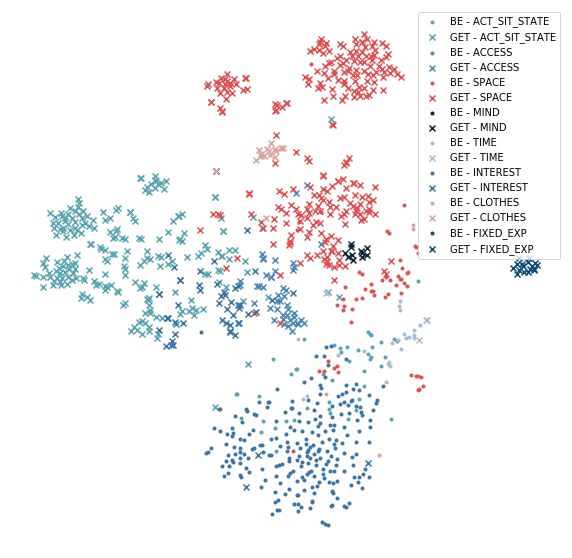

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
markers = ".", "x", "o"
colors = "#58A4B0", "#4D87B7", "#DE5050", "#0D2335", "#A9BCD0", "#3A74A4", "#DAA49A", "#0D4A7C"

for i, label in enumerate(set(sorted(y))):
    color = colors[i]
    for j, verb in enumerate(set(sorted(z))):
        if verb:
            marker = markers[j]
            _y = Y[(y == label) & (z == verb)]
            ax.scatter(_y[:, 0], _y[:, 1], label=f"{verb} - {label}", marker=marker, color=color)
ax.axis("off")
plt.legend()

To examine the relative position of tokens, and interactive plot (which allows zooming, and displays the examples when hovering over the tokens) can be plotted as well:

In [18]:
import altair as alt

Y_tsne = TSNE(perplexity=50, init='pca', verbose=True).fit_transform(X)

source_tsne = pd.DataFrame(Y_tsne, columns=["X", "Y"])
source_tsne["subtype2"] = df["subtype2"]
source_tsne["example"] = df["sent"]
source_tsne.head()

alt.Chart(source_tsne).mark_point().encode(
    x='X:Q',
    y='Y:Q',
    color='subtype2',
    tooltip=["subtype2", "example"]
).properties(
    width=500,
    height=500
).interactive()

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.020s...
[t-SNE] Computed neighbors for 1000 samples in 1.259s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 3.477659
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.495735
[t-SNE] KL divergence after 1000 iterations: 0.830669


alt.Chart(...)

# INTO-INTEREST RETRIEVAL

The procedure described here assumes that the researcher is simply interested in retrieving a particular usage of into in a large, unlabeled dataset.

In [19]:
import pandas as pd

df_all = pd.read_csv("../data/into_all_2000s.csv")
df_all = df_all.fillna("")
df_all["lhs"] = df_all["lhs"].str.lower().str.split().apply(' '.join)
df_all["rhs"] = df_all["rhs"].str.lower().str.split().apply(' '.join)
df_all = df_all[df_all['lhs'].str.strip() != ""]
df_all.head()

,number,file,lhs,match,rhs
0,153892,wlp_2000s_iey/fic_2004_28808.txt,"a gentle rain , rather like a summer shower th...",into,"mitford several months late . by six o'clock ,..."
1,153893,wlp_2000s_iey/fic_2004_28808.txt,"presence , and boundlessly grateful . cynthia ...",into,"his life , which , forthwith , she had changed..."
2,153894,wlp_2000s_iey/fic_2004_28808.txt,"@ @ @ @ @ @ @ @ @ day , first hying with his g...",into,"the pouring rain , and then , while the coffee..."
3,153895,wlp_2000s_iey/fic_2004_28808.txt,"jr . at talladega . he sighed deeply , hauled ...",into,"the unlaced , brown and white spectators he wo..."
4,153896,wlp_2000s_iey/fic_2004_28808.txt,"tryst . "" down with th ' mitford crud . prob'l...",into,a cold @ @ @ @ @ @ @ @ @ @ a pair of silver ni...


In [22]:
df_all["into_idx"] = df_all["lhs"].apply(lambda x: len(nlp.tokenizer(x)))
df_all["sent"] = df_all["lhs"].str.strip() + " into " + df_all["rhs"].str.strip()
df_all["sent"].head()

0    a gentle rain , rather like a summer shower th...
1    presence , and boundlessly grateful . cynthia ...
2    @ @ @ @ @ @ @ @ @ day , first hying with his g...
3    jr . at talladega . he sighed deeply , hauled ...
4    tryst . " down with th ' mitford crud . prob'l...
Name: sent, dtype: object

With the cell below, a random sample of 10,000 lines is taken from the full dataframe. In replicating the procedure, you may wish to consider reducing 'n_samples' to a smaller number, as creating embeddings for 10,000 examples may take a long time when the process is ran locally on your computer:

In [28]:
n_samples = 10000
df_samp = df_all.sample(n=n_samples)

In [31]:
pbar.close()

  0%|          | 5/10000 [00:08<4:30:27,  1.62s/it]


Create embeddings (Note: may take a long time!)

In [33]:
import tqdm

pbar = tqdm.tqdm_notebook(total=n_samples)

def encode(sent, index):
    doc = nlp(sent.lower())
    assert str(doc[index]) == "into"
    pbar.update(1)
    return doc[index].vector

df_samp["emb"] = df_samp[["sent", "into_idx"]].apply(lambda x: encode(x[0], x[1]), axis=1)

/Users/lauren/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


### FAISS: Fast Similarity search

In [36]:
import faiss
import numpy as np

emb = np.vstack(df_samp["emb"].values)

index = faiss.IndexFlatL2(emb[0].shape[0])
index.add(emb)
print(index.ntotal)

10000


In [67]:
df_query = df_samp.reset_index()

def most_similar(query, target="into", k=5):
    doc = nlp(query)
    tok_index = next(i for i, token in enumerate(doc) if str(token) == target)
    assert str(doc[tok_index]) == target
    query_vec = doc[tok_index].vector
    dists, neighbors = index.search(query_vec[:, np.newaxis].T, k)
    neighbors = neighbors[0]
    return [(df_query.loc[idx, "sent"], df_query.loc[idx, "number"], dist) for idx, dist in zip(neighbors, dists[0])]

In [80]:
def find_examples(query):
    results = []
    for i, (neighbor, id, dist) in enumerate(most_similar(query, k=100)): #k is number of examples
        results.append({"score": dist, "sent": neighbor})
    results = pd.DataFrame(results)
    return results

In [81]:
results = find_examples(
    "This should have been the high-light of the evening, but the audience just wasn't into it. "
)

results.to_csv("query1.csv", index=False)

,score,sent
0,116.188934,'ve given you hints on the best first moves to...
1,123.203560,"result . "" "" i knew it was trendy and all . th..."
2,128.052826,""" will you show me how ? "" <p> "" sure . "" <p> ..."
3,131.495499,"<p> generation y , bennett said , "" is into it..."
4,137.710815,"they 'll say : ' azaria nelson : bright , very..."
5,141.632751,they decided to make the television the only f...
6,143.566177,"her to move , and they got in a heated argumen..."
7,145.398529,into a movie and so immediately checked out . ...
8,154.594086,the seventies . this youngman was wearing bell...
9,162.222397,tickets a year in advance . for his birthday ....


In [97]:
results = find_examples(
    "they're creative and original, and that's something I'm very much into."
)

results.to_csv("query2.csv", index=False)

,score,sent
0,111.617249,"and looked much younger , thanks to hours work..."
1,125.489395,"result . "" "" i knew it was trendy and all . th..."
2,126.625572,they decided to make the television the only f...
3,126.749115,"<p> generation y , bennett said , "" is into it..."
4,127.958603,into a movie and so immediately checked out . ...
5,130.680206,tickets a year in advance . for his birthday ....
6,131.277985,business evens out both imbalances . gromov 's...
7,132.300018,"her to move , and they got in a heated argumen..."
8,135.327911,"they 'll say : ' azaria nelson : bright , very..."
9,137.497192,"songwriter , "" she says . "" is n't that cool ?..."


In [ ]:
results = find_examples(
    "Matt is the dopest guy in school and he’s into you."
)

results.to_csv("query3.csv", index=False)

In [107]:
results = find_examples(
    "I had sex with girls I didn't like because it was convenient. They were really into me, and it made me feel very guilty."
)

results.to_csv("query4.csv", index=False)

In [109]:
results = find_examples(
    "He was basically into being a hustler, which he was very, very good at."
)

results.to_csv("query5.csv", index=False)

In [114]:
results = find_examples(
    "Margret is 'into' astrology, and consults the I-Ching each morning."
)

results.to_csv("query6.csv", index=False)

In [116]:
results = find_examples(
    "She is a Libra, for those of you who are into that sort of thing."
)

results.to_csv("query7.csv", index=False)

In [122]:
results = find_examples(
    "Listen, it sounds like he's just not that into you."
)

results.to_csv("query8.csv", index=False)

In [124]:
results = find_examples(
    "He got so into math that he stayed inside almost all the time. He hardly wanted to play with his friends anymore "
)

results.to_csv("query9.csv", index=False)

In [131]:
results = find_examples(
    "Me and Dr. King , our philosophy is so different. I was more into what Malcolm was saying."
)

results.to_csv("query10.csv", index=False)

In [83]:
from sklearn.metrics import average_precision_score

def compute_ap(path):
    df = pd.read_csv(path)
    y_true, score = df["y_true"].values, -df["score"].values
    return average_precision_score(y_true, score)

In [143]:
compute_ap("query1.csv")

0.9242367611854189

In [136]:
compute_ap("query2.csv")

0.8948145926596012

In [138]:
compute_ap("query3.csv")

0.8943101759843192

In [140]:
compute_ap("query4.csv")

0.895045908445102

In [135]:
compute_ap("query5.csv")

0.8846951269588748

In [134]:
compute_ap("query6.csv")

0.9295377047720411

In [137]:
compute_ap("query7.csv")

0.9513941401429198

In [139]:
compute_ap("query8.csv")

0.8856872993969284

In [141]:
compute_ap("query9.csv")

0.8902971371028073

In [133]:
compute_ap("query10.csv")

0.8181207778134006

In [95]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def prec_rec_curve(path):
    df = pd.read_csv(path)
    y_true, score = df["y_true"].values, -df["score"].values
    prec, recall, _ = precision_recall_curve(y_true, score)
    fig, ax = plt.subplots()
    ax.plot(recall, prec)
    ax.set(xlabel="recall", ylabel="precision")
    return ax

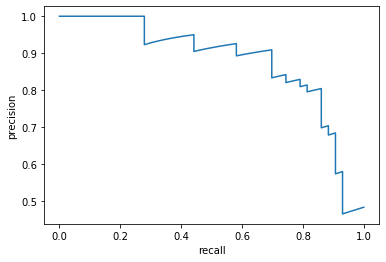

In [104]:
prec_rec_curve("query2.csv")